# Note:  
V2  
- Add adaptive performance index from only Macro F1 to any.  
pef_matric1='macro avg' or 'weighted avg', pef_matric2='f1-score', 'precision', or 'recall'
- Show performance as "macro avg - f1-score.  
- Add QDA model.  

V1 
- Combine all models in single file for doing further experiment, such as data preprocessing and feature engineering experiment further.
- Show all results of all models and plot it.
- Show performance as "macro avg - f1-score.

In [91]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

seed_no = 572

# import warnings
# warnings.filterwarnings("ignore")

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier


# Load data

In [58]:
df_trn = pd.read_csv('data/x_train_82.csv', index_col='index')
df_tst = pd.read_csv('data/x_test_82.csv', index_col='index')

In [59]:
print(df_trn.shape, df_tst.shape)
df_trn.head()

(847, 8) (212, 8)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
244,6.5,38,1,0,1,0,255,medium
824,6.8,45,0,0,0,1,255,medium
602,5.6,50,0,1,1,1,255,low
347,8.6,55,0,1,1,1,255,low
753,6.6,38,0,0,0,0,255,medium


# Data Preprocessing

In [60]:
def encode_label(df_in):
    df_fnc = df_in.copy()
    df_fnc.loc[df_fnc['Grade']=='low', 'Grade'] = 0
    df_fnc.loc[df_fnc['Grade']=='medium', 'Grade'] = 1
    df_fnc.loc[df_fnc['Grade']=='high', 'Grade'] = 2
    df_fnc['Grade'] = df_fnc['Grade'].astype(int)
    
    return df_fnc

df_trn = encode_label(df_trn)
df_tst = encode_label(df_tst)

In [61]:
df_trn.head(2)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
244,6.5,38,1,0,1,0,255,1
824,6.8,45,0,0,0,1,255,1


In [62]:
# Prepare for training
y_trn = df_trn[['Grade']]
X_trn = df_trn.drop(columns='Grade')

y_tst = df_tst[['Grade']]
X_tst = df_tst.drop(columns='Grade')

print(y_trn.shape, X_trn.shape)
print(y_tst.shape, X_tst.shape)

(847, 1) (847, 7)
(212, 1) (212, 7)


In [63]:
# Scaler
scaler = StandardScaler()
X_trn_scale = pd.DataFrame(scaler.fit_transform(X_trn))
X_trn_scale.columns = X_trn.columns
X_trn_scale.index = X_trn.index

X_tst_scale = pd.DataFrame(scaler.transform(X_tst))
X_tst_scale.columns = X_tst.columns
X_tst_scale.index = X_tst.index

In [64]:
X_trn_scale.head(2)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
index,,,,,,,
244,-0.091649,-0.607768,0.902056,-0.882843,0.691509,-0.989430,0.744513
824,0.122987,0.067163,-1.108579,-0.882843,-1.446112,1.010683,0.744513


# Train model

## CV - Hyperparameters tuning

In [65]:
def classification_rep(y_true, y_pred, dataname=""):

    ## Evaluate the model/log score
    dict_report = classification_report(y_true, y_pred, output_dict=True)
    print(f"Classification Report ({dataname}):")
    print(classification_report(y_true, y_pred))

    # Get the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix using a heatmap
    class_names = ['low', 'medium', 'high']
    plt.figure(figsize=(5, 3), facecolor='none')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    return dict_report

In [66]:
# Create a stratified 5-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_no)

In [67]:
# setting performance matric
# pef_matric1='macro avg' or 'weighted avg'
# pef_matric2='f1-score', 'precision', or 'recall'
matric1 = 'macro avg'
matric2 = 'f1-score'

### KNN

In [68]:
def model_knn(Xtrn, ytrn, Xtst, ytst, step_k=1, show_best_params=True, pef_matric1='macro avg', pef_matric2='f1-macro'):

    # Set the hyperparameters and their possible values
    param_grid = {
        'n_neighbors': range(1, int(Xtrn.shape[0]*0.79), 1),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
    }


    # Create the KNN classifier
    knn_classifier = KNeighborsClassifier()

    verbose_num = 1
    if show_best_params==False:
        verbose_num = 0
        # Create GridSearchCV object
    grid_search = GridSearchCV(knn_classifier, param_grid, cv=skf, 
                               scoring='f1_macro', verbose=verbose_num)

    # Perform grid search with cross-validation
    grid_search.fit(Xtrn, ytrn)

    # Get the best hyperparameters
    best_param = grid_search.best_params_

    # Use the best model to make predictions on the test set
    model_best_params = grid_search.best_estimator_

    # GridSearchCV return the retrained model with whole dataset
    ytrn_pred = model_best_params.predict(Xtrn)

    # Make predictions on the test set
    ytst_pred = model_best_params.predict(Xtst)
    
    
    if show_best_params==True:
        # Display the best hyperparameters
        print(f'Best hyperparameters: {best_param}')

        # Display the best cross-validation score
        best_score = grid_search.best_score_
        print(f'Best cross-validation score: {best_score}')
        ## Evaluate the model/log score
        dict_rep = classification_rep(ytrn, ytrn_pred, "Train")

        # Evaluate the model
        # Display classification report
        dict_rep_test = classification_rep(ytst, ytst_pred, "Test")

        
    # prep. return dataframe
    ret_cv_score = grid_search.best_score_
    ret_params = best_param
    ret_train_score = dict_rep[pef_matric1][pef_matric2]
    ret_test_score = dict_rep_test[pef_matric1][pef_matric2]
    df_ret = pd.DataFrame({'model': 'K-Nearest Neighbors',
                           'score_cv': ret_cv_score, 'score_train': ret_train_score, 
                           'score_test': ret_test_score, 'best_params': [ret_params]})

    return df_ret, model_best_params, grid_search

Fitting 5 folds for each of 2672 candidates, totalling 13360 fits
Best hyperparameters: {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}
Best cross-validation score: 0.998962417807806
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       343
           1       1.00      1.00      1.00       299
           2       1.00      1.00      1.00       205

    accuracy                           1.00       847
   macro avg       1.00      1.00      1.00       847
weighted avg       1.00      1.00      1.00       847



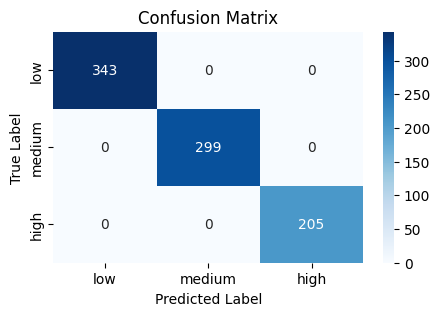

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       0.99      1.00      0.99        75
           2       1.00      0.98      0.99        51

    accuracy                           1.00       212
   macro avg       1.00      0.99      0.99       212
weighted avg       1.00      1.00      1.00       212



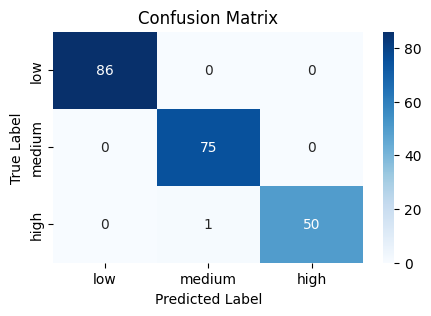

In [69]:
df_res_knn, knn_classifier, knn_grid_search = model_knn(X_trn_scale, y_trn, X_tst_scale, y_tst, 
                                       pef_matric1=matric1, pef_matric2=matric2)


Fitting 5 folds for each of 668 candidates, totalling 3340 fits


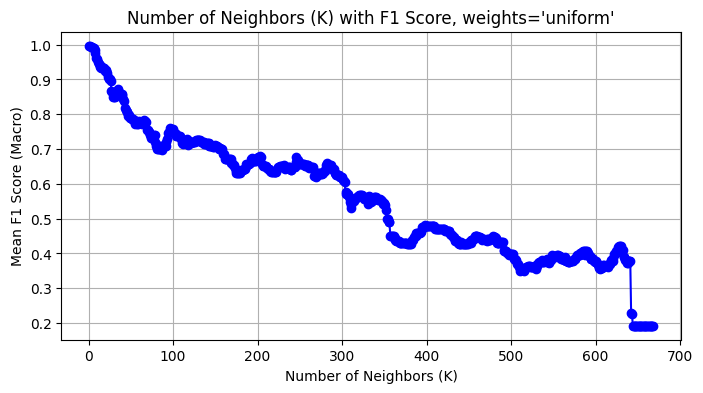

In [70]:
# {'n_neighbors': 21, 'p': 2, 'weights': 'distance'}
param_grid = {
    'n_neighbors': range(1, int(X_trn_scale.shape[0] * 0.79), 1),
}

# Create the KNN classifier
knn_classifier = KNeighborsClassifier(p=2, weights='uniform')

# Create GridSearchCV object
grid_search = GridSearchCV(knn_classifier, param_grid, cv=skf, scoring='f1_macro', verbose=1)

# Perform grid search with cross-validation
grid_search.fit(X_trn_scale, y_trn)

# Extract the results
results = grid_search.cv_results_

# Plot the elbow curve for 'n_neighbors'
plt.figure(figsize=(8, 4), facecolor='none')
plt.plot(results['param_n_neighbors'], results['mean_test_score'], marker='o', linestyle='-', color='b')
plt.title("Number of Neighbors (K) with F1 Score, weights='uniform'")
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean F1 Score (Macro)')
plt.grid(True)
plt.show()

Fitting 5 folds for each of 668 candidates, totalling 3340 fits


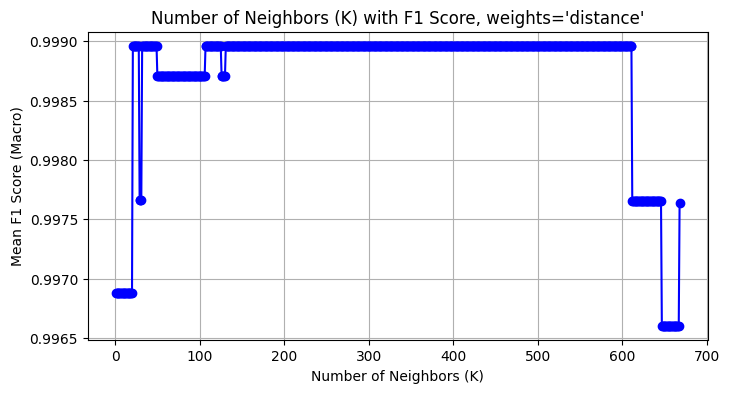

In [71]:
# {'n_neighbors': 21, 'p': 2, 'weights': 'distance'}
param_grid = {
    'n_neighbors': range(1, int(X_trn_scale.shape[0] * 0.79), 1),
}

# Create the KNN classifier
knn_classifier = KNeighborsClassifier(p=2, weights='distance')

# Create GridSearchCV object
grid_search = GridSearchCV(knn_classifier, param_grid, cv=skf, scoring='f1_macro', verbose=1)

# Perform grid search with cross-validation
grid_search.fit(X_trn_scale, y_trn)

# Extract the results
results = grid_search.cv_results_

# Plot the elbow curve for 'n_neighbors'
plt.figure(figsize=(8, 4), facecolor='none')
plt.plot(results['param_n_neighbors'], results['mean_test_score'], marker='o', linestyle='-', color='b')
plt.title("Number of Neighbors (K) with F1 Score, weights='distance'")
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean F1 Score (Macro)')
plt.grid(True)
plt.show()

### Adaboost

In [72]:
def model_adaboost(Xtrn, ytrn, Xtst, ytst, show_best_params=True, pef_matric1='macro avg', pef_matric2='f1-macro'):
    
    # Create an AdaBoostClassifier
    adaboost_classifier = AdaBoostClassifier(random_state=seed_no)

    # Define the hyperparameter grid to search
    param_grid_adaboost = {
        'n_estimators': [50, 100, 200, 500, 1000, 2000],
        'learning_rate': [0.01, 0.05, 0.1]
    }

    # Use GridSearchCV to search for the best hyperparameters
    verbose_num = 1
    if show_best_params==False:
        verbose_num = 0
    grid_search_adaboost = GridSearchCV(estimator=adaboost_classifier, 
                                         param_grid=param_grid_adaboost, 
                                         cv=skf, 
                                         scoring='f1_macro',
                                         verbose=verbose_num)
    grid_search_adaboost.fit(Xtrn, y_trn)
    
    # Get the best hyperparameters
    best_params_adaboost = grid_search_adaboost.best_params_

    # Use the best model to make predictions on the test set
    model_best_params = grid_search_adaboost.best_estimator_

    # GridSearchCV return the retrained model with whole dataset
    ytrn_pred = model_best_params.predict(Xtrn)

    # Make predictions on the test set
    ytst_pred = model_best_params.predict(Xtst)
    
    
    if show_best_params==True:
        print("Best Hyperparameters (Adaboost):", best_params_adaboost)
        print("Best Score (Adaboost):", grid_search_adaboost.best_score_)
        ## Evaluate the model/log score
        dict_rep = classification_rep(ytrn, ytrn_pred, "Train")

        # Evaluate the model
        # Display classification report
        dict_rep_test = classification_rep(ytst, ytst_pred, "Test")

        # Get feature importances
        feature_importances = model_best_params.feature_importances_  # using GridSearch

        # Get the corresponding feature names
        feature_names = list(Xtrn.columns)  # Assuming you have column names in your DataFrame X

        # Create a DataFrame to display feature importances
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

        # Sort the DataFrame by importance in descending order
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        # Print or visualize the feature importances
        display(importance_df)

        # Plotting feature importances 
        plt.figure(figsize=(8, 4), facecolor='none')
        plt.barh(importance_df['Feature'], importance_df['Importance'])
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('Feature Importances')
        plt.show()

    # prep. return dataframe
    ret_cv_score = grid_search_adaboost.best_score_
    ret_params = best_params_adaboost
    ret_train_score = dict_rep[pef_matric1][pef_matric2]
    ret_test_score = dict_rep_test[pef_matric1][pef_matric2]
    df_ret = pd.DataFrame({'model': 'AdaBoost',
                           'score_cv': ret_cv_score, 'score_train': ret_train_score, 
                           'score_test': ret_test_score, 'best_params': [ret_params]})
    return df_ret, model_best_params

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters (Adaboost): {'learning_rate': 0.01, 'n_estimators': 100}
Best Score (Adaboost): 0.9176147422285353
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       343
           1       0.87      0.95      0.91       299
           2       0.91      0.80      0.85       205

    accuracy                           0.93       847
   macro avg       0.93      0.91      0.92       847
weighted avg       0.93      0.93      0.93       847



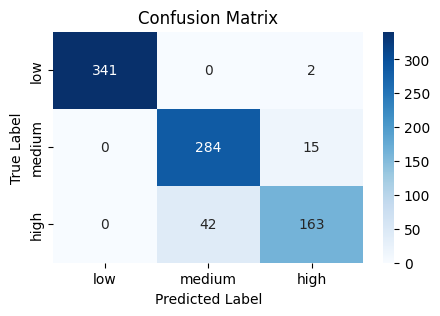

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        86
           1       0.86      0.95      0.90        75
           2       0.90      0.75      0.82        51

    accuracy                           0.92       212
   macro avg       0.92      0.90      0.90       212
weighted avg       0.92      0.92      0.92       212



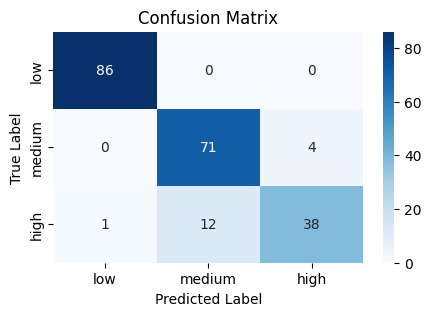

,Feature,Importance
5,Turbidity,0.38
3,Odor,0.29
0,pH,0.16
4,Fat,0.12
1,Temprature,0.05
2,Taste,0.00
6,Colour,0.00


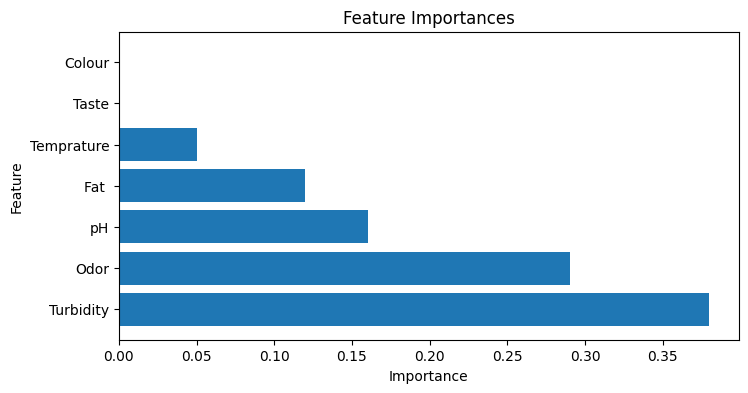

In [73]:
df_res_ada, ada_classifier = model_adaboost(X_trn_scale, y_trn, X_tst_scale, y_tst, 
                                            pef_matric1=matric1, pef_matric2=matric2)


### LDA

In [74]:
def model_lda(Xtrn, ytrn, Xtst, ytst, step_k=1, show_best_params=True, pef_matric1='macro avg', pef_matric2='f1-macro'):
    # Set the hyperparameters and their possible values
    param_grid = {
        'solver': ['svd', 'lsqr', 'eigen'],
        'shrinkage': [None, 'auto']
    }

    # Create the LDA classifier
    lda_classifier = LinearDiscriminantAnalysis()

    
    verbose_num = 1
    if show_best_params==False:
        verbose_num = 0
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(lda_classifier, param_grid, cv=skf, 
                               scoring='f1_macro', verbose=verbose_num)


    # Perform grid search with cross-validation
    grid_search.fit(Xtrn, ytrn)

    # Get the best hyperparameters
    best_param = grid_search.best_params_

    # Use the best model to make predictions on the test set
    model_best_params = grid_search.best_estimator_

    # GridSearchCV return the retrained model with whole dataset
    ytrn_pred = model_best_params.predict(Xtrn)

    # Make predictions on the test set
    ytst_pred = model_best_params.predict(Xtst)
    
    
    if show_best_params==True:
        # Display the best hyperparameters
        print(f'Best hyperparameters: {best_param}')

        # Display the best cross-validation score
        best_score = grid_search.best_score_
        print(f'Best cross-validation score: {best_score}')
        ## Evaluate the model/log score
        dict_rep = classification_rep(ytrn, ytrn_pred, "Train")

        # Evaluate the model
        # Display classification report
        dict_rep_test = classification_rep(ytst, ytst_pred, "Test")

        
    # prep. return dataframe
    ret_cv_score = grid_search.best_score_
    ret_params = best_param
    ret_train_score = dict_rep[pef_matric1][pef_matric2]
    ret_test_score = dict_rep_test[pef_matric1][pef_matric2]
    df_ret = pd.DataFrame({'model': 'Linear Discriminant Analysis',
                           'score_cv': ret_cv_score, 'score_train': ret_train_score, 
                           'score_test': ret_test_score, 'best_params': [ret_params]})

    return df_ret, model_best_params

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters: {'shrinkage': None, 'solver': 'svd'}
Best cross-validation score: 0.7506897347919901
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.84      0.65      0.73       343
           1       0.72      0.90      0.80       299
           2       0.65      0.66      0.65       205

    accuracy                           0.74       847
   macro avg       0.74      0.74      0.73       847
weighted avg       0.75      0.74      0.74       847



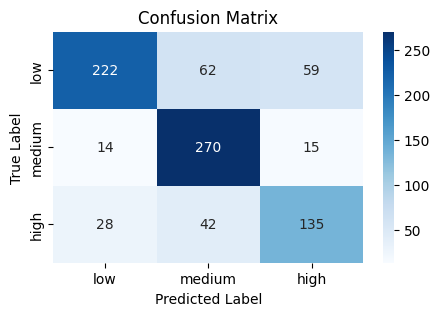

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.83      0.60      0.70        86
           1       0.69      0.88      0.77        75
           2       0.62      0.65      0.63        51

    accuracy                           0.71       212
   macro avg       0.71      0.71      0.70       212
weighted avg       0.73      0.71      0.71       212



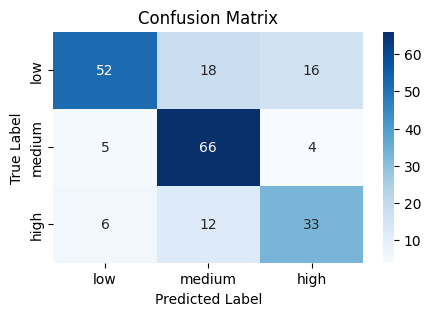

In [75]:
df_res_lda, lda_classifier = model_lda(X_trn_scale, y_trn, X_tst_scale, y_tst, 
                                            pef_matric1=matric1, pef_matric2=matric2)

### QDA

In [76]:
def model_qda(Xtrn, ytrn, Xtst, ytst, show_best_params=True, pef_matric1='macro avg', pef_matric2='f1-macro'):

    # Define the hyperparameter grid to search
    param_grid_qda = {'reg_param': np.linspace(0, 1, 100)}
#     param_grid_qda = {'reg_param': [0, 0.01, 0.02, 0.03, 0.04, 0.05]}
    
    # Create the QDA model
    qda = QuadraticDiscriminantAnalysis()

    # Use GridSearchCV to search for the best hyperparameters
    verbose_num = 1
    if show_best_params==False:
        verbose_num = 0
    # Create a grid search object
    grid_search = GridSearchCV(qda, param_grid=param_grid_qda,
                               cv=skf, scoring='accuracy', verbose=verbose_num)

    # Fit the grid search to the data
    grid_search.fit(Xtrn, ytrn)
    
    # Get the best hyperparameters
    best_params = grid_search.best_params_

    # Use the best model to make predictions on the test set
    model_best_params = grid_search.best_estimator_

    # GridSearchCV return the retrained model with whole dataset
    ytrn_pred = model_best_params.predict(Xtrn)

    # Make predictions on the test set
    ytst_pred = model_best_params.predict(Xtst)
    
    if show_best_params==True:
        print("Best Hyperparameters (QDA):", best_params)
        print("Best Score (QDA):", grid_search.best_score_)
        ## Evaluate the model/log score
        dict_rep = classification_rep(ytrn, ytrn_pred, "Train")

        # Evaluate the model
        # Display classification report
        dict_rep_test = classification_rep(ytst, ytst_pred, "Test")

    # prep. return dataframe
    ret_cv_score = grid_search.best_score_
    ret_params = best_params
    ret_train_score = dict_rep[pef_matric1][pef_matric2]
    ret_test_score = dict_rep_test[pef_matric1][pef_matric2]
    df_ret = pd.DataFrame({'model': 'Quadratic Discriminant Analysis',
                           'score_cv': ret_cv_score, 'score_train': ret_train_score, 
                           'score_test': ret_test_score, 'best_params': [ret_params]})
    return df_ret, model_best_params

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters (QDA): {'reg_param': 0.010101010101010102}
Best Score (QDA): 0.9445248868778281
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       343
           1       0.98      0.87      0.92       299
           2       0.83      1.00      0.91       205

    accuracy                           0.94       847
   macro avg       0.94      0.95      0.94       847
weighted avg       0.95      0.94      0.95       847



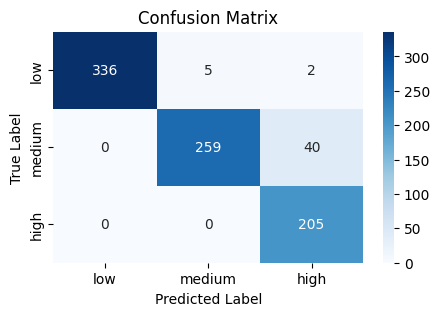

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        86
           1       0.97      0.87      0.92        75
           2       0.82      0.98      0.89        51

    accuracy                           0.93       212
   macro avg       0.93      0.94      0.93       212
weighted avg       0.94      0.93      0.93       212



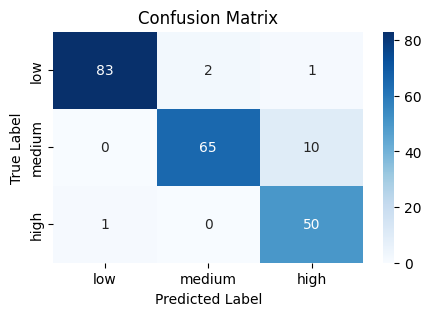

In [77]:
df_res_qda, qda_classifier = model_qda(X_trn_scale, y_trn, X_tst_scale, y_tst, 
                                            pef_matric1=matric1, pef_matric2=matric2)

### Logistic Regression

In [78]:
def model_lr(Xtrn, ytrn, Xtst, ytst, show_best_params=True, pef_matric1='macro avg', pef_matric2='f1-macro'):

    # Create a Logistic Regression classifier
    logreg_classifier = LogisticRegression(random_state=seed_no)

    # Define the hyperparameter grid to search for Logistic Regression
    param_grid_logreg = {
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'max_iter': [50, 100, 150, 200, 500]
    }

    verbose_num = 1
    if show_best_params==False:
        verbose_num = 0
    # Use GridSearchCV to search for the best hyperparameters
    grid_search_logreg = GridSearchCV(estimator=logreg_classifier,
                                       param_grid=param_grid_logreg,
                                       cv=skf,
                                       scoring='f1_macro',
                                       verbose=verbose_num)
    grid_search_logreg.fit(Xtrn, ytrn)

    # Get the best hyperparameters
    best_params_logreg = grid_search_logreg.best_params_


    # Use the best model to make predictions on the test set
    model_best_params = grid_search_logreg.best_estimator_
    
    ytrn_pred = model_best_params.predict(Xtrn)
    ytst_pred = model_best_params.predict(Xtst)
    
    if show_best_params==True:
        print("Best Hyperparameters (Logistic Regression):", best_params_logreg)
        print("Best Score (Logistic Regression):", grid_search_logreg.best_score_)
        
        ## Evaluate the model/log score
        dict_rep = classification_rep(ytrn, ytrn_pred, "Train")

        # Evaluate the model
        dict_rep_test = classification_rep(ytst, ytst_pred, "Test")
        
        # Access the coefficients
        coefficients = model_best_params.coef_[0]

        # Get the corresponding feature names
        feature_names = X_trn.columns  # Replace this with the actual feature names used in your model

        # Create a dictionary to store feature names and their coefficients
        feature_importance = dict(zip(feature_names, coefficients))

        # Sort features by their absolute coefficients for better visualization
        sorted_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

        # Extract sorted feature names and coefficients
        sorted_feature_names, sorted_coefficients = zip(*sorted_features)

        # Plotting
        plt.figure(figsize=(8, 4), facecolor='none')
        plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center')
        plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature Name')
        plt.title('Feature Importance')
        plt.show()
        
        
    # prep. return dataframe
    ret_cv_score = grid_search_logreg.best_score_
    ret_params = best_params_logreg
    ret_train_score = dict_rep[pef_matric1][pef_matric2]
    ret_test_score = dict_rep_test[pef_matric1][pef_matric2]
    df_ret = pd.DataFrame({'model': 'Logistic Regression',
                           'score_cv': ret_cv_score, 'score_train': ret_train_score, 
                           'score_test': ret_test_score, 'best_params': [ret_params]})
    return df_ret, model_best_params

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Hyperparameters (Logistic Regression): {'C': 10, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score (Logistic Regression): 0.8519325420195587
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       343
           1       0.94      0.85      0.89       299
           2       0.73      0.83      0.78       205

    accuracy                           0.86       847
   macro avg       0.85      0.85      0.85       847
weighted avg       0.86      0.86      0.86       847



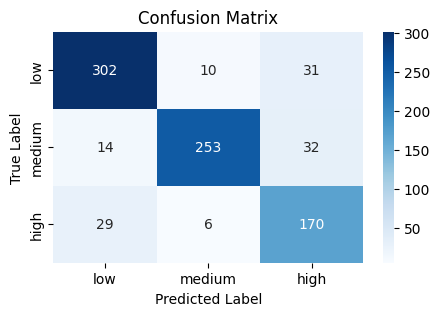

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        86
           1       0.95      0.81      0.88        75
           2       0.69      0.88      0.78        51

    accuracy                           0.84       212
   macro avg       0.84      0.85      0.84       212
weighted avg       0.86      0.84      0.85       212



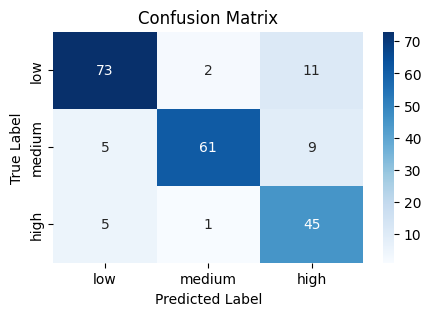

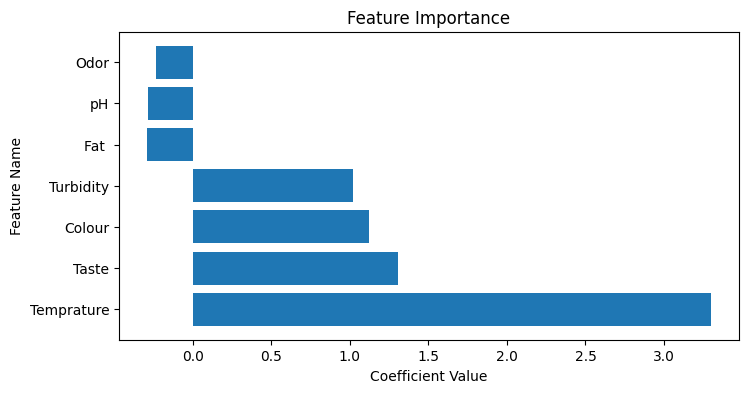

In [79]:
df_res_lr, lr_classifier = model_lr(X_trn_scale, y_trn, X_tst_scale, y_tst, 
                                            pef_matric1=matric1, pef_matric2=matric2)


### NaiveBayes

In [80]:
def model_nb(Xtrn, ytrn, Xtst, ytst, show_best_params=True, pef_matric1='macro avg', pef_matric2='f1-macro'):
        
        # Set the hyperparameters and their possible values
    param_grid = {
        'var_smoothing': np.logspace(0, -9, num=10)
    }

    # Create the KNN classifier
    nb_classifier = GaussianNB()

    verbose_num = 1
    if show_best_params==False:
        verbose_num = 0
        # Create GridSearchCV object
    grid_search = GridSearchCV(nb_classifier, param_grid, cv=skf, 
                               scoring='f1_macro', verbose=verbose_num)

    # Perform grid search with cross-validation
    grid_search.fit(Xtrn, ytrn)

    # Get the best hyperparameters
    best_param = grid_search.best_params_

    # Use the best model to make predictions on the test set
    model_best_params = grid_search.best_estimator_

    # GridSearchCV return the retrained model with whole dataset
    ytrn_pred = model_best_params.predict(Xtrn)

    # Make predictions on the test set
    ytst_pred = model_best_params.predict(Xtst)
    
    
    if show_best_params==True:
        # Display the best hyperparameters
        print(f'Best hyperparameters: {best_param}')

        # Display the best cross-validation score
        best_score = grid_search.best_score_
        print(f'Best cross-validation score: {best_score}')
        ## Evaluate the model/log score
        dict_rep = classification_rep(ytrn, ytrn_pred, "Train")

        # Evaluate the model
        # Display classification report
        dict_rep_test = classification_rep(ytst, ytst_pred, "Test")

        
    # prep. return dataframe
    ret_cv_score = grid_search.best_score_
    ret_params = best_param
    ret_train_score = dict_rep[pef_matric1][pef_matric2]
    ret_test_score = dict_rep_test[pef_matric1][pef_matric2]
    df_ret = pd.DataFrame({'model': 'NaiveBayes',
                           'score_cv': ret_cv_score, 'score_train': ret_train_score, 
                           'score_test': ret_test_score, 'best_params': [ret_params]})
    return df_ret, model_best_params

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'var_smoothing': 0.1}
Best cross-validation score: 0.9258695130856782
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.93      0.97       343
           1       0.94      0.89      0.92       299
           2       0.84      1.00      0.91       205

    accuracy                           0.94       847
   macro avg       0.93      0.94      0.93       847
weighted avg       0.94      0.94      0.94       847



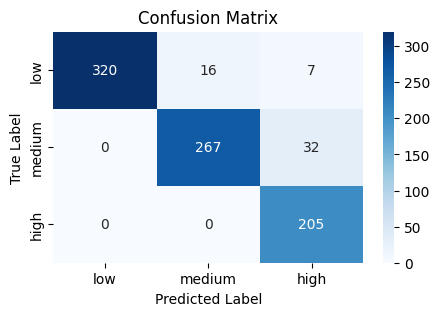

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.92      0.95        86
           1       0.93      0.88      0.90        75
           2       0.82      0.98      0.89        51

    accuracy                           0.92       212
   macro avg       0.91      0.93      0.92       212
weighted avg       0.93      0.92      0.92       212



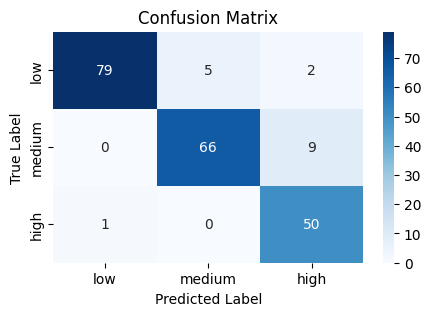

In [81]:
df_res_nb, nb_classifier = model_nb(X_trn_scale, y_trn, X_tst_scale, y_tst, 
                                            pef_matric1=matric1, pef_matric2=matric2)


### RandomForest

In [82]:
def model_rf(Xtrn, ytrn, Xtst, ytst, show_best_params=True, pef_matric1='macro avg', pef_matric2='f1-macro'):

    # Create a RandomForestClassifier
    rf_classifier = RandomForestClassifier(random_state=seed_no)

    # Define the hyperparameter grid to search
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [5, 10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    verbose_num = 1
    if show_best_params==False:
        verbose_num = 0
    # Use GridSearchCV to search for the best hyperparameters
    grid_search = GridSearchCV(estimator=rf_classifier, 
                               param_grid=param_grid, 
                               cv=skf, 
                               scoring='f1_macro',
                               verbose=verbose_num)
    grid_search.fit(Xtrn, ytrn)

    # # Get the best hyperparameters
    best_params = grid_search.best_params_

    # Use the best model to make predictions on the test set
    best_rf_model = grid_search.best_estimator_
    
    ytrn_pred = best_rf_model.predict(Xtrn)
    ytst_pred = best_rf_model.predict(Xtst)
    
    if show_best_params==True:
        print("Best Hyperparameters:", best_params)
        print("Best Score:", grid_search.best_score_)
        
        ## Evaluate the model/log score
        dict_rep = classification_rep(ytrn, ytrn_pred, "Train")

        # Evaluate the model
        dict_rep_test = classification_rep(ytst, ytst_pred, "Test")
        
        # Get feature importances
        # feature_importances = rf_classifier.feature_importances_  # manual CV
        feature_importances = best_rf_model.feature_importances_  # using GridSearch

        # Get the corresponding feature names
        feature_names = list(X_trn.columns)  # Assuming you have column names in your DataFrame X

        # Create a DataFrame to display feature importances
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

        # Sort the DataFrame by importance in descending order
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        # Print or visualize the feature importances
        display(importance_df)

        # Plotting feature importances (optional)
        plt.figure(figsize=(8, 4), facecolor='none', dpi=300)
        plt.barh(importance_df['Feature'], importance_df['Importance'])
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('Feature Importances')
        plt.show()
        
        
        # Merge prediction with the testing dataset
        df_test_perf = ytst.copy()
        df_test_perf['pred_test'] = ytst_pred
        df_test_perf = X_tst_scale.merge(df_test_perf, left_index=True, right_index=True)

        # Explore Error
        df_error = df_test_perf[df_test_perf['Grade']!=df_test_perf['pred_test']]
        print(f"Number of False Prediction: {df_error.shape[0]} ({(100*df_error.shape[0]/ytst.shape[0]):.02f}%)")
        display(df_test_perf[df_test_perf['Grade']!=df_test_perf['pred_test']])
        
        
    # prep. return dataframe
    ret_cv_score = grid_search.best_score_
    ret_params = best_params
    ret_train_score = dict_rep[pef_matric1][pef_matric2]
    ret_test_score = dict_rep_test[pef_matric1][pef_matric2]
    df_ret = pd.DataFrame({'model': 'Random Forest',
                           'score_cv': ret_cv_score, 'score_train': ret_train_score, 
                           'score_test': ret_test_score, 'best_params': [ret_params]})
    return df_ret, best_rf_model

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best Score: 0.998962417807806
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       343
           1       1.00      1.00      1.00       299
           2       1.00      1.00      1.00       205

    accuracy                           1.00       847
   macro avg       1.00      1.00      1.00       847
weighted avg       1.00      1.00      1.00       847



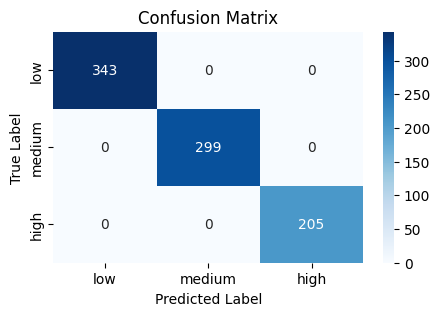

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       0.99      1.00      0.99        75
           2       1.00      0.98      0.99        51

    accuracy                           1.00       212
   macro avg       1.00      0.99      0.99       212
weighted avg       1.00      1.00      1.00       212



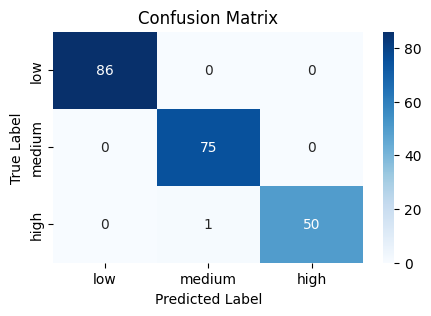

,Feature,Importance
0,pH,0.371765
1,Temprature,0.225531
5,Turbidity,0.105552
4,Fat,0.097731
3,Odor,0.088176
2,Taste,0.057687
6,Colour,0.053560


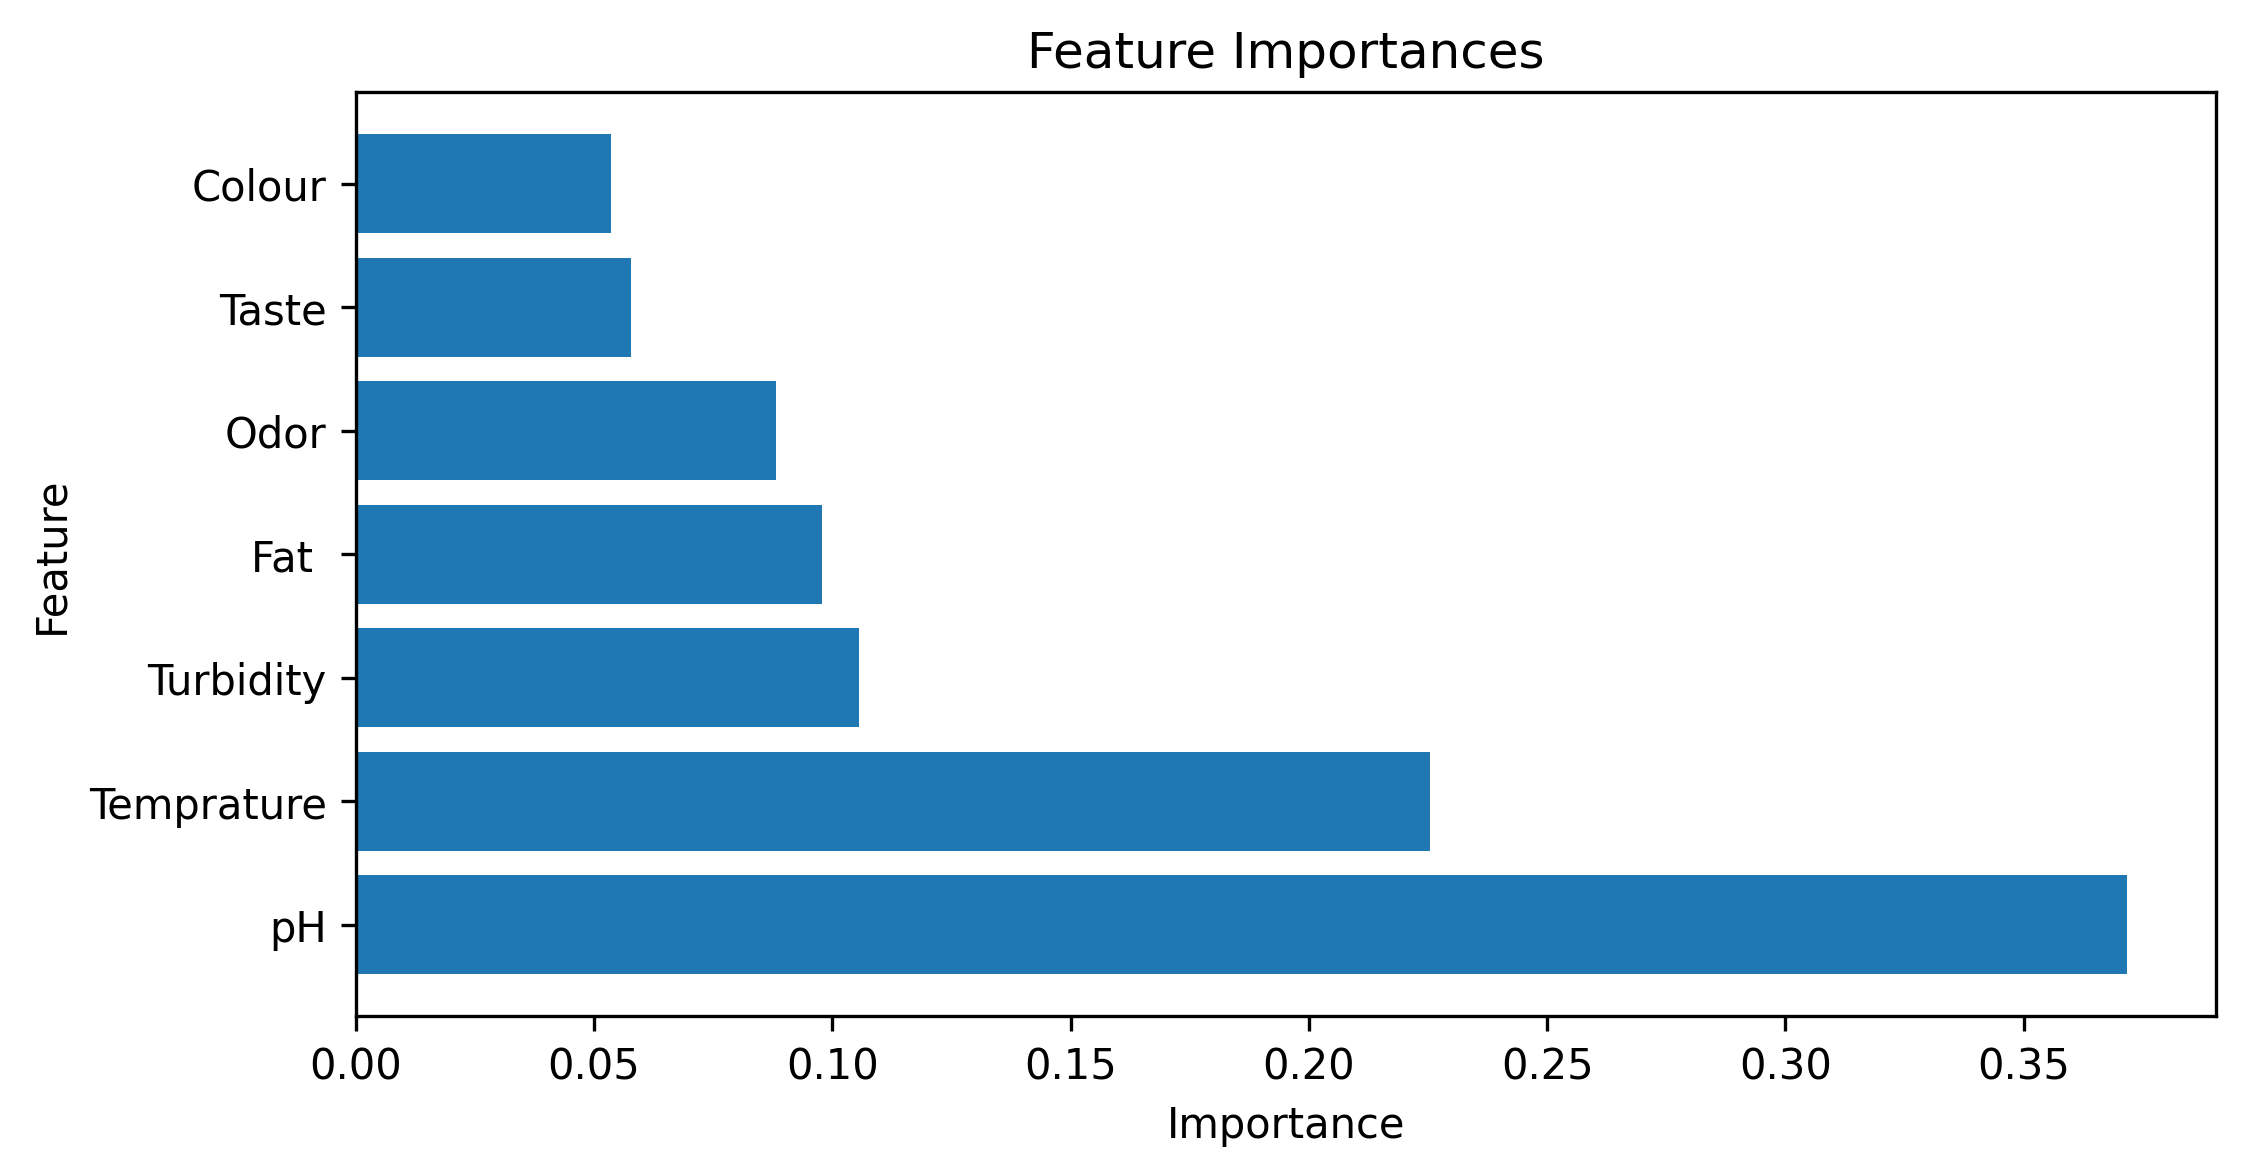

Number of False Prediction: 1 (0.47%)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade,pred_test
index,,,,,,,,,
1,-0.020104,-0.800605,-1.108579,1.132704,-1.446112,1.010683,0.288216,2,1


In [83]:
df_res_rf, rf_classifier = model_rf(X_trn_scale, y_trn, X_tst_scale, y_tst, 
                                            pef_matric1=matric1, pef_matric2=matric2)


In [84]:
X_tst_scale.iloc[[81]]

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
index,,,,,,,
1,-0.020104,-0.800605,-1.108579,1.132704,-1.446112,1.010683,0.288216


,Feature,Importance
0,pH,0.371765
1,Temprature,0.225531
5,Turbidity,0.105552
4,Fat,0.097731
3,Odor,0.088176
2,Taste,0.057687
6,Colour,0.053560


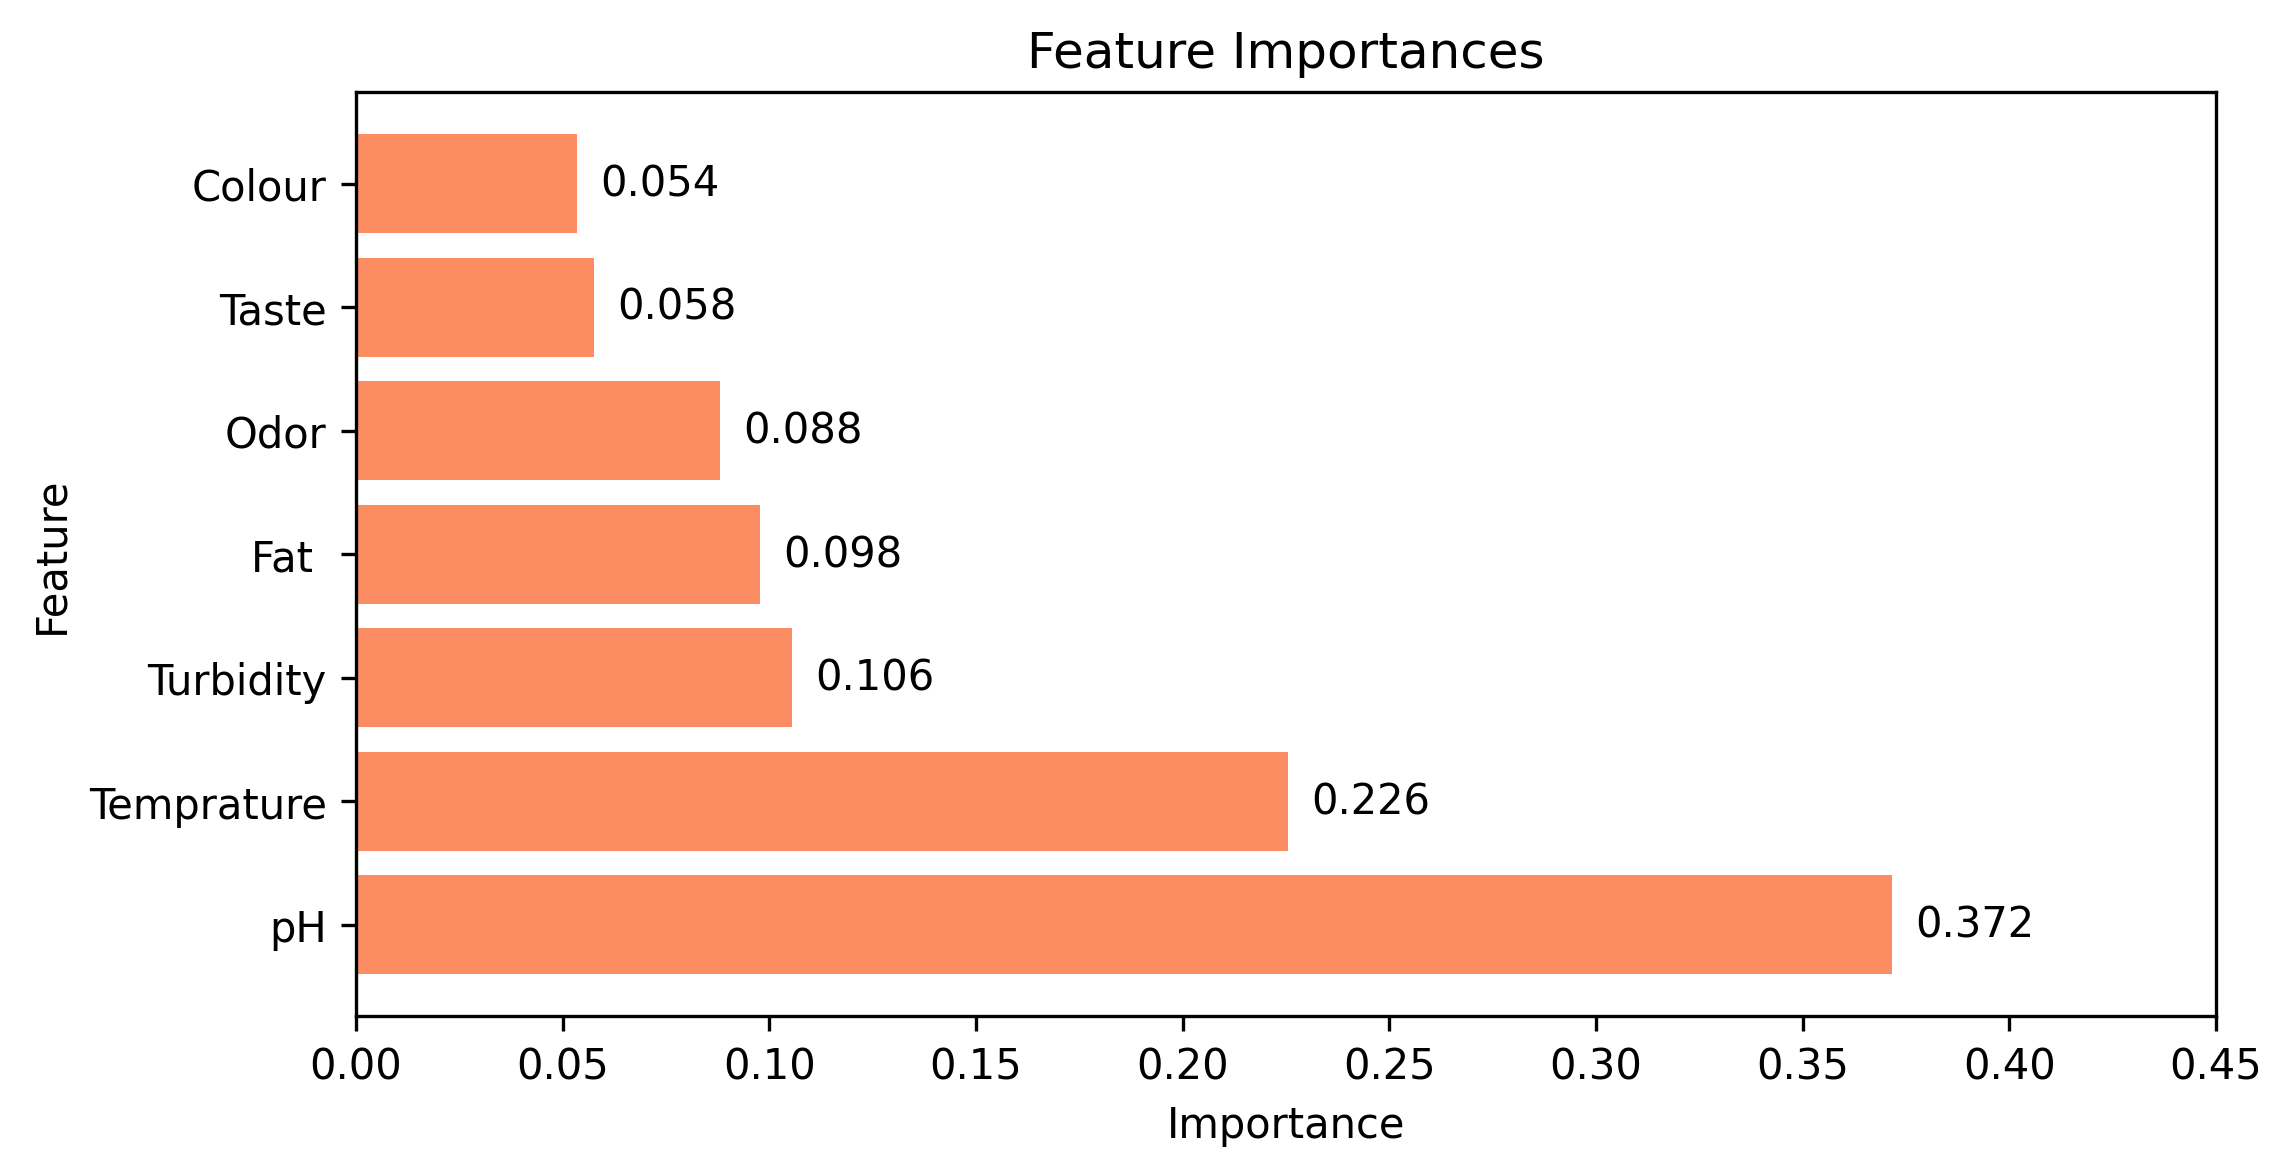

In [85]:
feature_importances = rf_classifier.feature_importances_  # using GridSearch

# Get the corresponding feature names
feature_names = list(X_trn.columns)  # Assuming you have column names in your DataFrame X

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
display(importance_df)

# Plotting feature importances (optional)
plt.figure(figsize=(8, 4), facecolor='none', dpi=300)
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='#fc8d62')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.xlim(0, 0.45)

# Add text values for each bar
for bar, value in zip(bars, importance_df['Importance']):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f'{value:.3f}', ha='center', va='center')

plt.show()

In [86]:
import shap
shap.initjs()

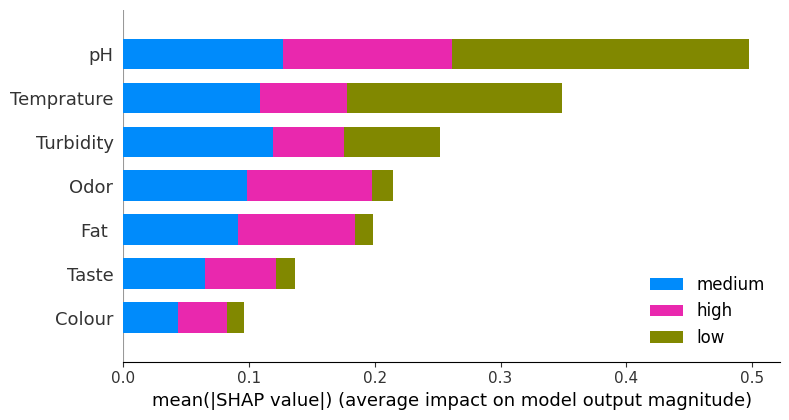

In [87]:
# Calculate SHAP values
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_tst_scale)

# Summary plot to visualize feature importance
shap.summary_plot(shap_values, X_tst_scale, 
                  feature_names=[f"{col}" for col in X_tst_scale.columns],
                  class_names=['low', 'medium', 'high'], )



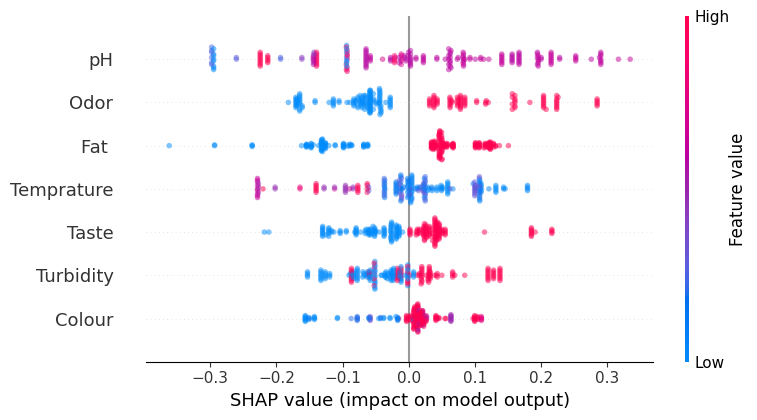

In [88]:
shap.summary_plot(shap_values[2], X_tst_scale, alpha=0.5)


### SVM

In [92]:
def model_svm(Xtrn, ytrn, Xtst, ytst, show_best_params=True, pef_matric1='macro avg', pef_matric2='f1-macro'):

    # Create a Support Vector Machines (SVM) classifier
    svm_classifier = SVC(random_state=seed_no)

    # Define the hyperparameter grid to search for SVM
    param_grid_svm = {
        'C': [0.1, 1, 5, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }

    verbose_num = 1
    if show_best_params==False:
        verbose_num = 0
    # Use GridSearchCV to search for the best hyperparameters
    grid_search_svm = GridSearchCV(estimator=svm_classifier, 
                                   param_grid=param_grid_svm, 
                                   cv=skf, 
                                   scoring='f1_macro',
                                   verbose=verbose_num)
    grid_search_svm.fit(Xtrn, ytrn)

    # Get the best hyperparameters
    best_params_svm = grid_search_svm.best_params_

    # Use the best model to make predictions on the test set
    model_best_params = grid_search_svm.best_estimator_

    ytrn_pred = model_best_params.predict(Xtrn)
    ytst_pred = model_best_params.predict(Xtst)

    if show_best_params==True:
        print("Best Hyperparameters (SVM):", best_params_svm)
        print("Best Score (SVM):", grid_search_svm.best_score_)
        ## Evaluate the model/log score
        dict_rep = classification_rep(ytrn, ytrn_pred, "Train")

        # Evaluate the model
        dict_rep_test = classification_rep(ytst, ytst_pred, "Test")
        
    # prep. return dataframe
    ret_cv_score = grid_search_svm.best_score_
    ret_params = best_params_svm
    ret_train_score = dict_rep[pef_matric1][pef_matric2]
    ret_test_score = dict_rep_test[pef_matric1][pef_matric2]
    df_ret = pd.DataFrame({'model': 'Support Vector Machine',
                           'score_cv': ret_cv_score, 'score_train': ret_train_score, 
                           'score_test': ret_test_score, 'best_params': [ret_params]})
    return df_ret, model_best_params

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters (SVM): {'C': 1, 'gamma': 1, 'kernel': 'poly'}
Best Score (SVM): 0.9965495639900095
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       343
           1       1.00      1.00      1.00       299
           2       1.00      1.00      1.00       205

    accuracy                           1.00       847
   macro avg       1.00      1.00      1.00       847
weighted avg       1.00      1.00      1.00       847



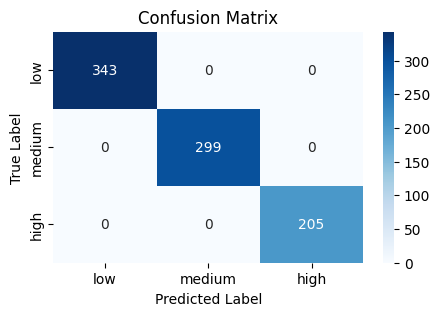

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       0.99      1.00      0.99        75
           2       1.00      0.98      0.99        51

    accuracy                           1.00       212
   macro avg       1.00      0.99      0.99       212
weighted avg       1.00      1.00      1.00       212



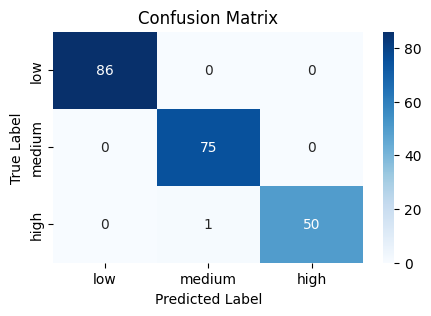

In [93]:
df_res_svm, svm_classifier = model_svm(X_trn_scale, y_trn, X_tst_scale, y_tst, 
                                            pef_matric1=matric1, pef_matric2=matric2)


## Combine Results

In [94]:
df_res = pd.concat([df_res_ada, df_res_knn, df_res_lda,
                    df_res_qda,
                    df_res_lr, df_res_nb, df_res_rf,
                    df_res_svm]).reset_index(drop=True)
df_res['dataprep'] = 'scaled'

In [95]:
df_res.sort_values('score_test', ascending=False)

,model,score_cv,score_train,score_test,best_params,dataprep
1,K-Nearest Neighbors,0.998962,1.000000,0.994492,"{'n_neighbors': 21, 'p': 1, 'weights': 'distance'}",scaled
6,Random Forest,0.998962,1.000000,0.994492,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}",scaled
7,Support Vector Machine,0.996550,1.000000,0.994492,"{'C': 1, 'gamma': 1, 'kernel': 'poly'}",scaled
3,Quadratic Discriminant Analysis,0.944525,0.938947,0.928274,{'reg_param': 0.010101010101010102},scaled
5,NaiveBayes,0.925870,0.931992,0.916258,{'var_smoothing': 0.1},scaled
0,AdaBoost,0.917615,0.917543,0.903386,"{'learning_rate': 0.01, 'n_estimators': 100}",scaled
4,Logistic Regression,0.851933,0.848336,0.839155,"{'C': 10, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}",scaled
2,Linear Discriminant Analysis,0.750690,0.728673,0.701511,"{'shrinkage': None, 'solver': 'svd'}",scaled


In [96]:
df_res.to_csv('score_test_scaled.csv', encoding='utf-8-sig', index=False)

### plot


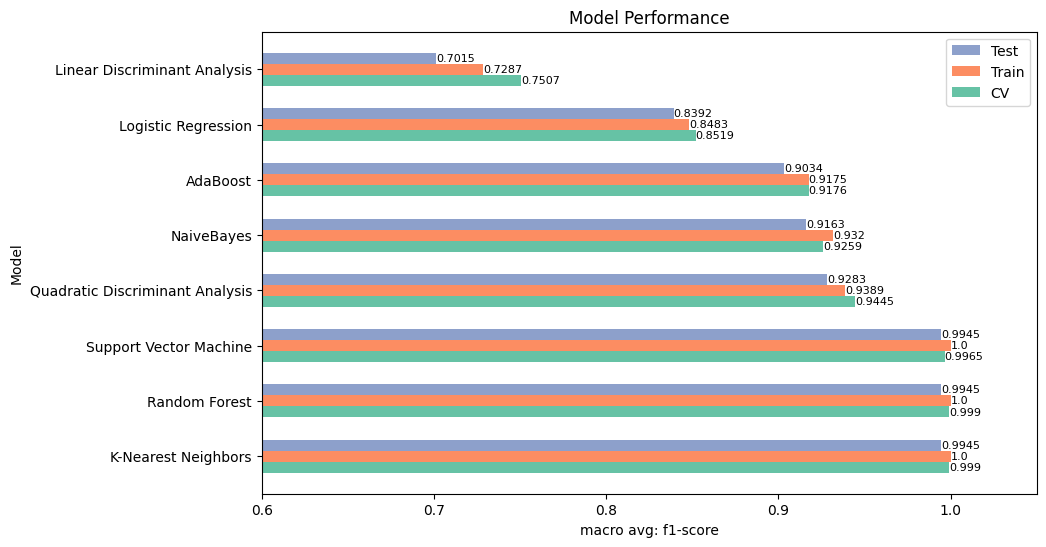

In [97]:
# Sort the dataframe based on the Test Score
df_res = df_res.sort_values(by='score_test', ascending=False)

# Define pastel colors
soft_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# Plotting the bar chart with pastel colors
fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')
bar_width = 0.2
bar_positions = np.arange(len(df_res['model']))

# Plotting each score with pastel colors
ax.barh(bar_positions - bar_width, df_res['score_cv'], bar_width, label='CV', color=soft_colors[0])
ax.barh(bar_positions, df_res['score_train'], bar_width, label='Train', color=soft_colors[1])
ax.barh(bar_positions + bar_width, df_res['score_test'], bar_width, label='Test', color=soft_colors[2])

# Adding text labels on the right of each bar with rotation
def add_labels(bars):
    for bar in bars:
        xval = bar.get_width()
        plt.text(xval, bar.get_y() + bar.get_height()/2, round(xval, 4), ha='left', 
                 va='center', fontsize=8)

add_labels(ax.patches)

# Adding labels and title
ax.set_yticks(bar_positions)
ax.set_yticklabels(df_res['model'])
ax.set_xlabel(f'{matric1}: {matric2}')
ax.set_xlim(0.6, 1.05)
ax.set_ylabel('Model')
ax.set_title('Model Performance')

# Reordering the legend labels to match the order of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper right')

# Show the plot
plt.show()